# DeepFeature: DeepInsight CAM-based Feature Selection Example

This example shows a case of using class activation maps (CAMs) and a trained model to identify important features in class prediction as proposed in *[DeepFeature: feature selection in nonimage data using convolutional neural network](https://doi.org/10.1093/bib/bbab297)*. The first three sections are the same steps taken in the [pyTorch SqueezeNet example](./pytorch_squeezenet.ipynb). Please see that example for a fuller explaination of these steps. 

### Jump to section
* [TCGA RNASeq2GeneNorm data](#load_data)
* [DeepInsight: Image Transformation](#deepinsight)
* [SqueezeNet Image Classification](#squeezenet)
* **[DeepFeature: CAM-based Feature Selection](#deepfeature)**

In [1]:
from pyDeepInsight import ImageTransformer, LogScaler, CAMFeatureSelector

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

<a id='load_data'></a>
## TCGA RNASeq2GeneNorm data

Here we load the TCGA primary tumor RNASeq data for 8 cancer types as described in the data [README.md](./data/README.md#curatedTCGAData_RNASeq2GeneNorm-20160128)

In [2]:
expr_file = r"./data/curatedTCGAData_RNASeq2GeneNorm-20160128.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
genes = expr.iloc[:, 2:].columns.to_numpy()

random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

In [3]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

<a id='deepinsight'></a>
## DeepInsight: Image Transformation
Convert data to image format using DeepInsight

In [4]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    square_distances=True,
    n_jobs=-1
)
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

In [5]:
X_train_img = it.fit_transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

<a id='squeezenet'></a>
## SqueezeNet Image Classification
Train SqueezeNet CNN

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
net = torch.hub.load(
    'pytorch/vision:v0.10.0', 'squeezenet1_1', 
    pretrained=True, verbose=False)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), 
                              stride=(1,1))
net = net.to(device)

In [8]:
batch_size=200
preprocess = transforms.Compose([transforms.ToTensor()])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(le.fit_transform(y_train)).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(le.transform(y_test)).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), 
    lr=1e-04,
    momentum=0.8,
    weight_decay=1e-05
)

In [10]:
net.train()
for epoch in range(200):
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [11]:
test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")

The test accuracy was 0.973


<a id='deepfeature'></a>
## DeepFeature: CAM-based Feature Selection

The feature selection method uses the class activation maps of all samples in a class to identify important features for differenting classes. The DeepInsight CAM-base feature selection is done in 3 steps.

Step 1: create the `CAMFeatureSelector` object. This class must be provided with the previously constructed DeepInsight `ImageTransformer` object and the CNN model trained using the output of that object. In addition, there are two optional parameters: 

* target_layer: the layer of the CNN model to use to compute the CAM. This can be the name of the layer or the layer itself. If none is given, CAMFeatureSelector will choose an appropriate layer using methods from the package [torchcam](https://github.com/frgfm/torch-cam).
* cam_method: name of the CAM method from the package [grad-cam](https://github.com/jacobgil/pytorch-grad-cam). The default is "GradCAM".

In [12]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    target_layer='classifier.2',
    cam_method=cm_method
)

Step 2: calculate the CAM for each input image and then combine into a single CAM for each class via the given method. 'Mean' returns the mean of each pixel across all inputs of a class, 'max' returns the maximum value observed for each pixel and acts as the union, and 'min' returns the minimum value observed for each pixel and acts as the intersect. Batch size can be provided to optimize speed versus memory usage.

In [13]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

Step 3: feature selection for each class is performed by identifying feature indicies mapped to coordinates of the CAM that pass the threshold.

In [14]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

From this a list of selected features for each class can be extracted.

In [15]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]} features selected for {le_mapping[cat]}: {', '.join(feature_names[1:5])}...")

939 features selected for BRCA: A2ML1, A4GALT, A4GNT, AACS...
2708 features selected for HNSC: A1CF, A4GALT, AAAS, AACSL...
2205 features selected for KIRC: ABCC11, ABCF2, ABCG1, ABHD13...
801 features selected for LGG: ABCB11, ABCG1, ABHD14B, ABHD15...
1488 features selected for LUAD: ADRBK2, ADRM1, AFF2, AFF4...
3360 features selected for LUSC: A2LD1, A2ML1, A2M, A4GNT...
1279 features selected for THCA: A2BP1, A2ML1, A4GALT, AAAS...
5144 features selected for UCEC: A2LD1, AAA1, AADACL2, AADACL3...


An image representing the CAM can be generated using the [grad_cam](https://github.com/jacobgil/pytorch-grad-cam)'s `show_cam_on_image` and [Matplotlib](https://matplotlib.org/).

In [16]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

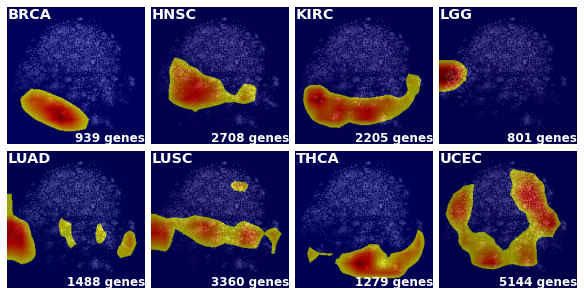

In [17]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

### Changing the flattening method

#### flatten_method="max"
As the max CAM value is selected for each pixel, this selects all features that passed threshold in any member of the class - in essence a union of all features that passed the threshold for all individual samples of a class. This will select more features with a broader relationship to class prediction.

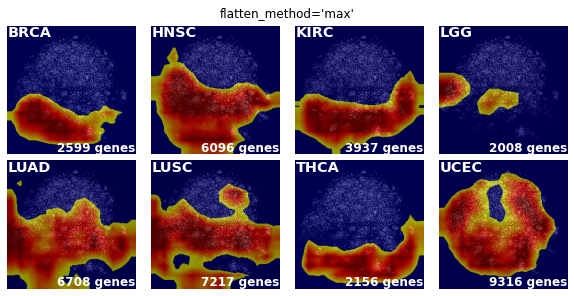

In [18]:
fl_method = 'max'

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}'")
plt.show()

#### flatten_method="min"
As the min CAM value is selected for each pixel, this selects only features that passed threshold in *all* members of the class - in essence a intesect of features that passed the threshold for all individual samples of a class. This will select less features with a stronger relationship to class prediction.

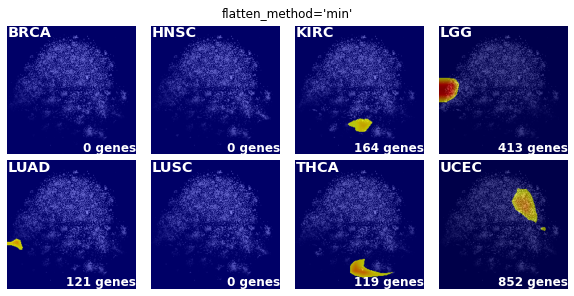

In [19]:
fl_method = 'min'

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}'")
plt.show()

### Changing the threshold

Another way to alter the number of features selected is to change the CAM threshold at which features are selected.

Let's once again use 'mean' as the flattening method.

In [20]:
fl_method = 'mean'
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

#### threshold=0.9
A higher threshold will select less features.

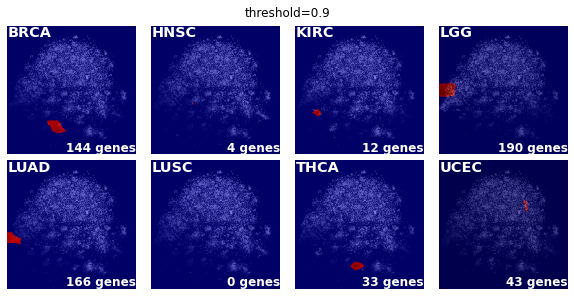

In [21]:
fs_threshold=0.9

feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"threshold={fs_threshold}")
plt.show()

#### threshold=0.3
A lower threshold will select more features.

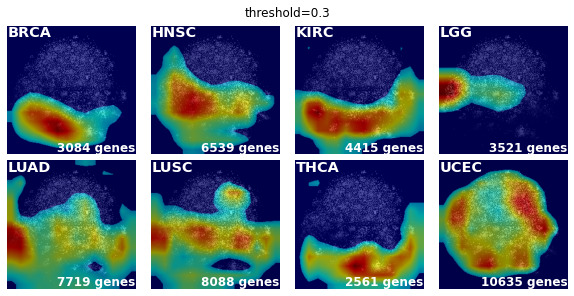

In [22]:
fs_threshold=0.3

feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"threshold={fs_threshold}")
plt.show()

### Combining flattening method and threshold 

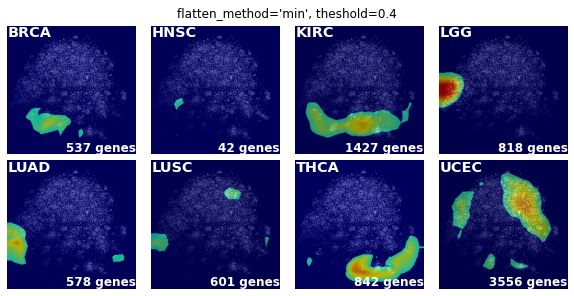

In [23]:
fl_method = 'min'
fs_threshold = 0.4

class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)
fig, _ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)
fig.suptitle(f"flatten_method='{fl_method}', theshold={fs_threshold}")
plt.show()